# Carga de librerias, configuraciones previas y funciones a usar

In [1]:
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.

mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': 20})

In [3]:
def cm2inch(cm):
    return cm/2.54

def gaussBckgrnd(x,m,s,M,b0,b1):
    z = (m-x)/s
    gauss = M*np.exp(-0.5*z**2)
    fondo = b0 + b1 * (x - m)
    return gauss + fondo

def tandem(x,m1,s1,M1,m2,s2,M2,b0,b1):
    z1 = (m1-x)/s1
    gauss1 = M1*np.exp(-0.5*z1**2)
    z2 = (m2-x)/s2
    gauss2 = M2*np.exp(-0.5*z2**2)
    mm = (m1 + m2)/2
    fondo = b0 + b1 * (x - mm)
    return gauss1 + gauss2 + fondo

def recta(x,b0,b1,x0):
    return b0 + b1 * (x-x0)

def gauss(x,m,s,M):
    z = (m-x)/s
    return M*np.exp(-0.5*z**2)

# toma las salidas de curve_fit: parámetros= pot, matriz de covariaza = pcov
# La diagonal de la matriz de covarianza es la covarianza de cada parámetro. Su raíz cuadrada es la desviación estándar.
def statsGauss_tabla(popt,pcov):
    mu = popt[0] 
    stdv_mu = np.sqrt(pcov[0,0])
    
    s = popt[1]
    s = np.abs(s) # curve_fit puede producir s < 0, sin efecto adverso. 
    stdv_s = np.sqrt(pcov[1,1])
    
    M = popt[2]
    stdv_M = np.sqrt(pcov[2,2])
    
    b0 = popt[3]
    stdv_b0 = np.sqrt(pcov[3,3])
    
    b1 = popt[4]
    stdv_b1 = np.sqrt(pcov[4,4])
    
    I = np.sqrt(2*np.pi)*s*M
    stdv_I = I * np.sqrt((stdv_s/s)**2 + (stdv_M/M)**2) 

    print('   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) ')
    print('{0:4.2f}({1:2.2f}) &{2:4.1f}({3:2.1f}) &{4:3.1f}({5:2.1f}) &{6:5.0f}({7:3.0f})  \\\\'.format(M,stdv_M,mu,stdv_mu,s,stdv_s,I,stdv_I))

# 5.3.1 Parafina
## 1. Ajuste en la región $E_\gamma \approx 662$ keV
### Empezando con la muestra de aire:

In [4]:
f0 = pd.read_csv('parafina-aire.csv') #Importanto datos

x0 = f0.iloc[:,0].to_numpy()
y0 = f0.iloc[:,1].to_numpy()

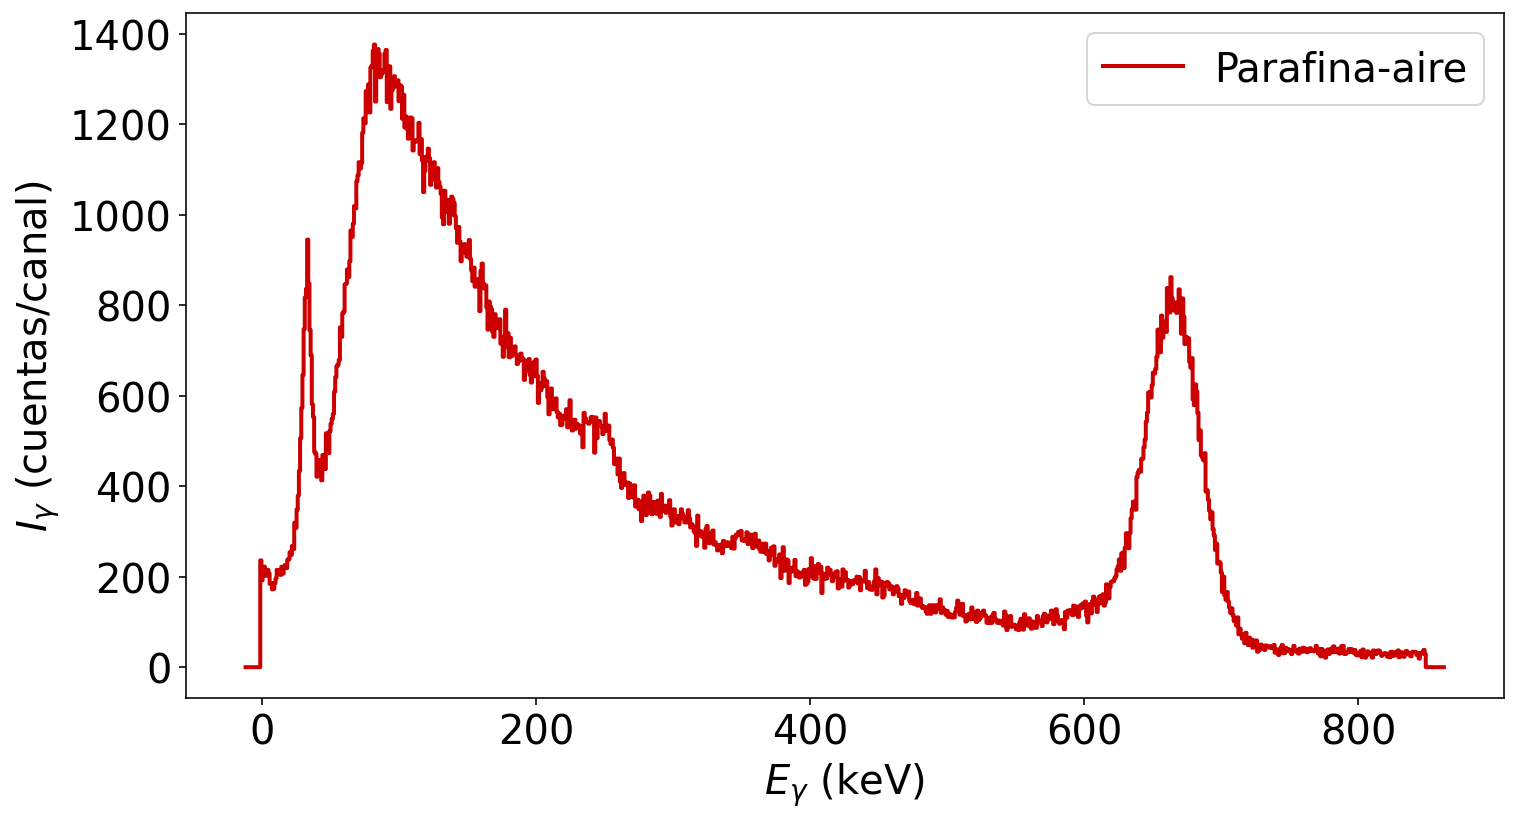

In [5]:
fig, ax = plt.subplots(1,1,figsize=(cm2inch(30.0),cm2inch(16.0)))
plt.plot(x0,y0,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1),label='Parafina-aire') #color (R,G,B,intensidad)
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)')
plt.legend();

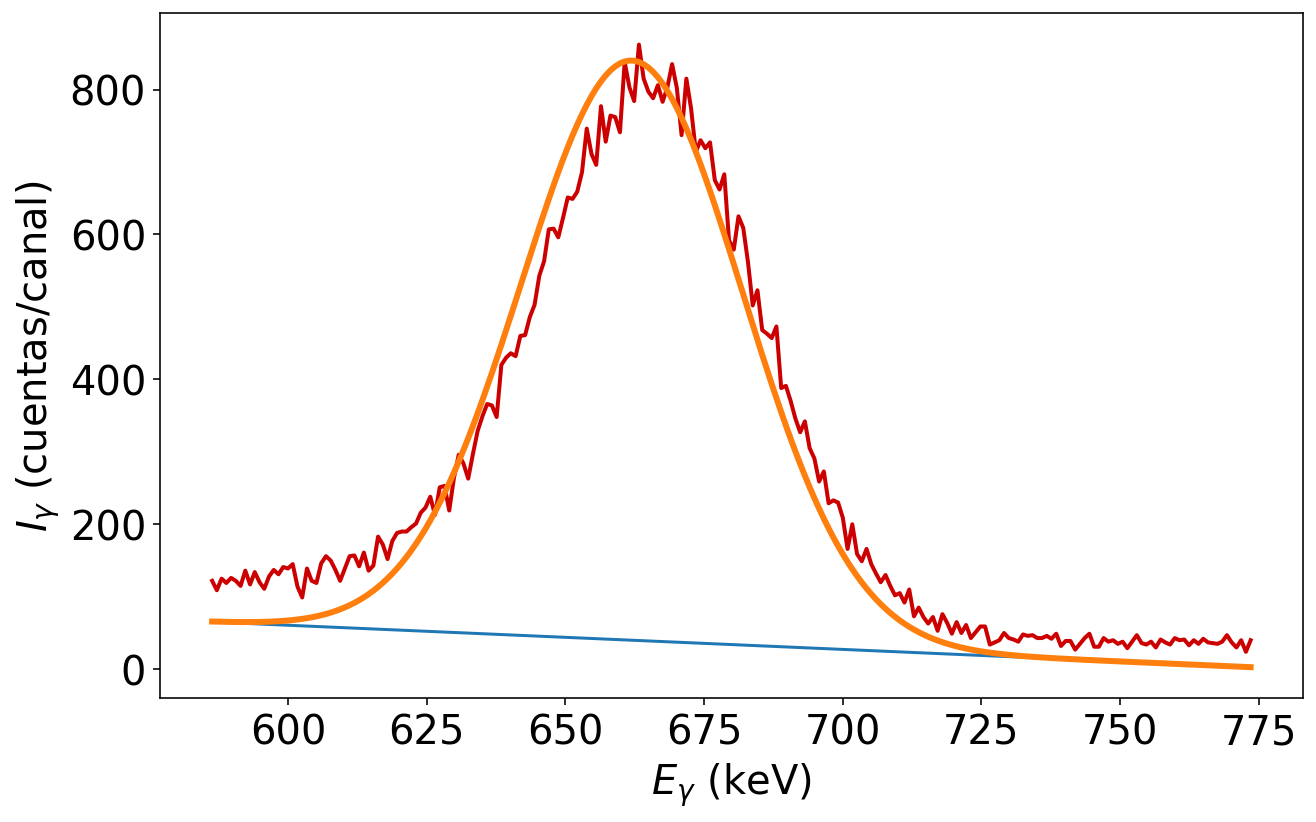

In [6]:
#Seleccionando la zona de interés.
x=x0[700:920] #ojo, esos índices corresponden a las posiciones del vector NO a los valores de energía
y=y0[700:920]
fig, ax =plt.subplots(1,1,figsize=(cm2inch(26.0),cm2inch(16.0)))
ax.plot(x,y,linewidth=2,color=(0.8,0,0,1))
# siguientes líneas: inicialización de los parámetros de ajuste , parámetros puestos a ojo.
mu = 662      #mitad de la campana
s = 20        #ancho medio
M = 800       #altura
b0 = 40       #corte con el eje y de la recta
b1 = -40/120  #pendiente de la recta
rf = recta(x,b0,b1,mu)
plt.plot(x,rf)
gf = gaussBckgrnd(x,mu,s,M,b0,b1)
ax.plot(x,gf,lw=3); # Miramos qué tan buenos son los parámetros graficando con ellos (sin ajustar todavía)
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)');

In [7]:
p0 = np.array([mu,s,M,b0,b1]) #vector de parámetros para el ajuste
popt, pcov = curve_fit(gaussBckgrnd,x,y,p0,sigma=np.sqrt(y)) #comando curve_fit para ajustar gaussiana y recta
#popt retorna los parámetros de p0 pero ajustados

   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) 
726.67(6.19) &664.4(0.2) &19.6(0.2) &35675(409)  \\


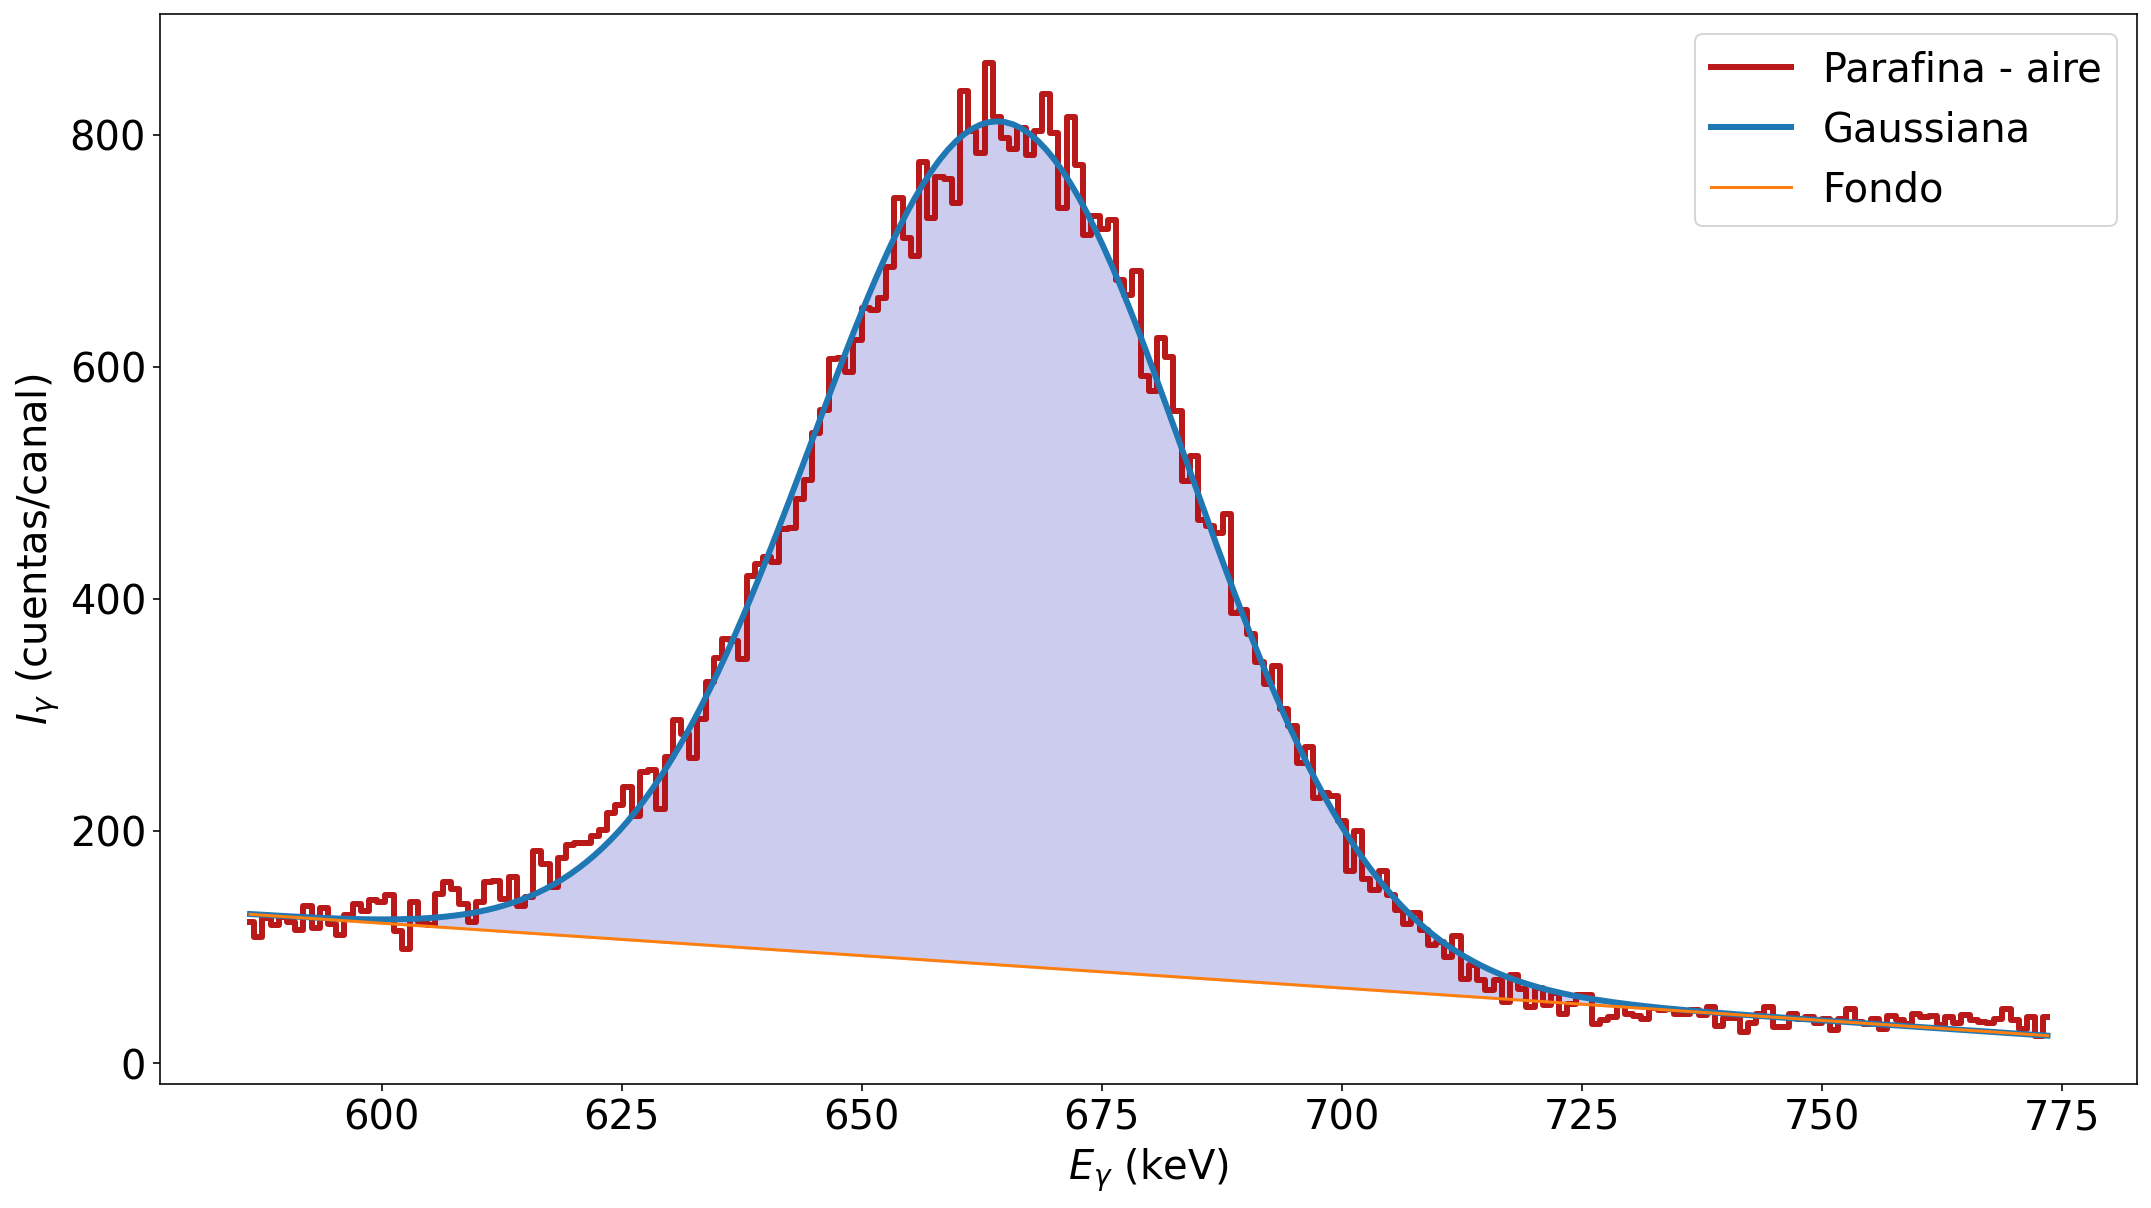

In [8]:
mu,s,M,b0,b1 = popt
y_fit = gaussBckgrnd(x,mu,s,M,b0,b1)  #Gaussiana
r_fit = recta(x,b0,b1,mu)             #Recta

#Graficando
fig, ax = plt.subplots(1,1,figsize=(cm2inch(45.0),cm2inch(25.0)))
datos,= ax.plot(x,y,drawstyle='steps-mid',linewidth=3,color=(0.7,0,0,0.9))
datos.set_label('Parafina - aire')

curva_gauss,= ax.plot(x,y_fit,lw=3)
curva_gauss.set_label('Gaussiana')

recta_gauss,=ax.plot(x,r_fit)
recta_gauss.set_label('Fondo')

ax.fill_between(x,r_fit,y_fit,color=(0,0,0.7,0.2))
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)')
ax.legend()

plt.savefig("parafina-aire.png", dpi=150)

#Tabla de parámetros y sus incertiumbres
statsGauss_tabla(popt,pcov) # La salida produce resultados listos para incluir y editar en latex. Pero falta depurar la notación de las incertidumbres...